In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler

import math

In [5]:
f = uproot.open('/Users/jshlomi/Desktop/Datasets/TruthTagging/datasetNewFormat_800k.root')

In [6]:
for key in f.keys():
    print(key)

b'h1dR0;1'
b'h1dR1;1'
b'h1dR2;1'
b'h1eta;1'
b'h1;1'
b't1;1'


In [7]:
for key in f['t1'].keys():
    print(key, f['t1'].array(key)[0])

b'jet_pt' [750.594     61.12262   45.023663]
b'jet_eta' [-0.44284642 -0.20170802  1.772796  ]
b'jet_phi' [-2.6190274  -1.2963486   0.92201716]
b'jet_label' [2 1 3]
b'jet_score' [0.58708245 0.36451545 0.79709184]
b'jet_eff' [0.15771769 0.9336995  0.02277992]
b'jet_tag' [0 1 0]
b'nJets' 3
b'mass' 268.26273


In [8]:
f['t1'].numentries

800000

In [9]:
f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_tag'],entrystart=10,entrystop=15).reset_index()

,entry,subentry,jet_pt,jet_eta,jet_phi,jet_label,jet_tag
0,10,0,388.419159,-0.219824,-0.299123,1,1
1,10,1,50.619904,-1.782675,-1.399243,3,0
2,10,2,33.118786,0.738623,-1.429117,1,1
3,11,0,218.037491,-1.452783,-1.907602,1,1
4,11,1,217.952530,1.250095,-0.812666,1,1
5,11,2,198.621689,-1.472275,0.589758,2,0
6,11,3,100.988602,1.275110,-2.963007,1,1
7,12,0,194.384262,1.711038,-2.475176,1,1
8,12,1,164.029663,0.918173,-0.471601,3,0
9,13,0,202.414612,1.209149,-1.553285,2,0


## split the dataset to training and validation sets

In [10]:
n_entries = f['t1'].numentries
training_split = 600000

def collect_jets(entrystart,entry_stop):
    df = f['t1'].pandas.df(['jet_pt','jet_eta','jet_phi','jet_label','jet_eff','jet_score'],
                           entrystart=entrystart,entrystop=entry_stop).reset_index()
    df['jet_tag'] = 1*(df.jet_score < df.jet_eff)
    return df

jets_train_data = collect_jets(0,training_split)
jet_valid_data = collect_jets(training_split,n_entries)

event_df_train = f['t1'].pandas.df(['mass'],entrystart=0,entrystop=training_split)
event_df_valid = f['t1'].pandas.df(['mass'],entrystart=training_split)

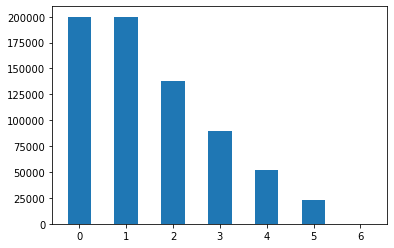

In [11]:
plt.hist(jet_valid_data['subentry'],bins=np.linspace(-0.25,6.25,14));

## create a 2D (pt/eta) efficiency map from the training dataset

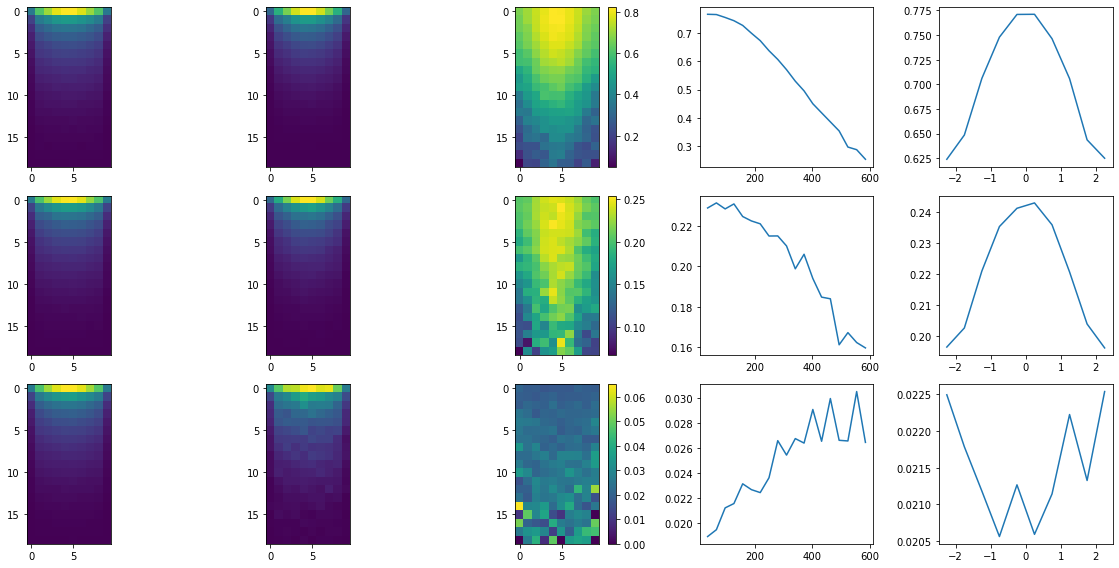

In [12]:
fig,ax = plt.subplots(3,5,figsize=(16,8))

eff_maps = {
    1: None,
    2: None,
    3: None,
}

for flav_i, flav in enumerate([1,2,3]):
    flav_cut = np.where(jets_train_data['jet_label']==flav)[0]
    
    pt_values = jets_train_data['jet_pt'].values[flav_cut]
    eta_values = jets_train_data['jet_eta'].values[flav_cut]
    istagged_values = jets_train_data['jet_tag'].values[flav_cut]

    pt_bins = np.linspace(20,600,20)
    eta_bins = np.linspace(-2.5,2.5,11)

    tagged_jets = np.where(istagged_values ==1)[0]
    total_histogram = np.histogram2d(pt_values,eta_values,bins=(pt_bins,eta_bins))
    pass_histogram = np.histogram2d(pt_values[tagged_jets],eta_values[tagged_jets],bins=(pt_bins,eta_bins))

    eff_map = np.divide(pass_histogram[0],total_histogram[0])

    ax[flav_i][0].imshow(total_histogram[0],aspect=1)
    ax[flav_i][1].imshow(pass_histogram[0],aspect=1)
    pos = ax[flav_i][2].imshow(eff_map,aspect=1)
    fig.colorbar(pos, ax=ax[flav_i][2])
    
    eff_maps[flav] = eff_map.copy()
    
    
    pt_projection = np.divide(pass_histogram[0].sum(axis=1),total_histogram[0].sum(axis=1))

    
    eta_projection = np.divide(pass_histogram[0].sum(axis=0),total_histogram[0].sum(axis=0))

    
    ax[flav_i][3].plot([0.5*(pt_bins[i+1]+pt_bins[i]) for i in range(len(pt_bins)-1)],pt_projection)
    ax[flav_i][4].plot([0.5*(eta_bins[i+1]+eta_bins[i]) for i in range(len(eta_bins)-1)],eta_projection)
plt.tight_layout()
plt.show()

## apply efficiency map to validation set and compute truth tag weights

In [13]:
def apply_effmaps(ds):

    pt_values = ds['jet_pt'].values
    eta_values = ds['jet_eta'].values

    results_effs = np.zeros(len(pt_values))

    for flav in [1,2,3]:
        flav_cut = np.where( ds['jet_label'].values==flav )[0]

        bins = [ 
                [np.min([x,len(pt_bins)-1])-1 for x in np.digitize(pt_values[flav_cut],pt_bins)],
              [np.min([x,len(eta_bins)-1])-1 for x in np.digitize(eta_values[flav_cut],eta_bins)] 
        ]

        effs = eff_maps[flav][tuple(bins)]

        results_effs[flav_cut] = effs

    
        ds['map_eff'] = results_effs

apply_effmaps(jet_valid_data)
apply_effmaps(jets_train_data)

In [14]:
effs_1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['map_eff'].values
effs_2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['map_eff'].values

tt_weights = {
 0: (1-effs_1)*(1-effs_2),
 1: (effs_1)*(1-effs_2)+(1-effs_1)*(effs_2),
 2: (effs_1)*(effs_2)
}



## compute direct tagging

In [15]:
jet_1_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==0]
jet_2_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==1]

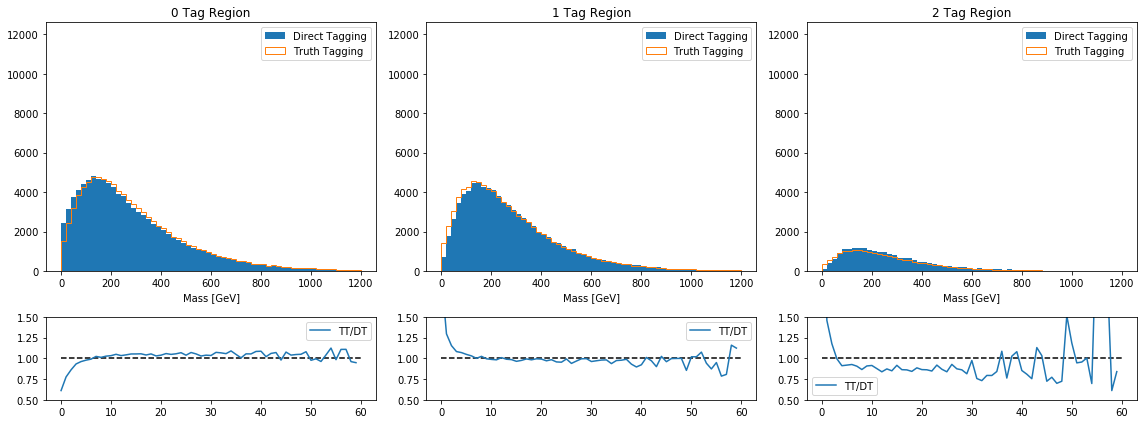

In [14]:
fig,ax = plt.subplots(2,3,figsize=(16,6),gridspec_kw={'height_ratios':[3,1]})



for plot_i, ntags in enumerate([0,1,2]):
    
    
    ax_i = ax[0][plot_i]
    
    if ntags==0:
        tag_condition = (jet_1_valid_target == 0) & (jet_2_valid_target == 0)
    elif ntags==1:
        tag_condition = (((jet_1_valid_target == 1) & (jet_2_valid_target == 0)) 
                         | ((jet_1_valid_target == 0) & (jet_2_valid_target == 1)) )
    elif ntags==2:
        tag_condition = (jet_1_valid_target == 1) & (jet_2_valid_target == 1)
    
    mass_binning = np.linspace(0,1200,61)
    h_dt = ax_i.hist(event_df_valid['mass'].values[tag_condition]
                     ,bins=mass_binning,label='Direct Tagging')
    h_tt = ax_i.hist(event_df_valid['mass'],weights=tt_weights[ntags],histtype='step',
              bins=mass_binning,
              label='Truth Tagging')
    
    ax[1][plot_i].plot([0,60],[1,1],color='k',linestyle='--')
    ax[1][plot_i].plot(h_tt[0]/h_dt[0],label='TT/DT')
    ax[1][plot_i].set_ylim(0.5,1.5)
    ax[1][plot_i].legend()
    ax_i.set_ylim(0,12600)
    ax_i.set_xlabel('Mass [GeV]')
    ax_i.set_title(str(ntags)+' Tag Region')
    ax_i.legend()
plt.tight_layout()
plt.show()

## create a neural network and train it

# we need to normalize the input variables

In [16]:
var_transformations = {}
for var_i,var  in enumerate(['jet_pt','jet_eta','jet_phi']):
    var_values = jets_train_data[var].values
    var_transformations[var] = [np.mean(var_values),np.std(var_values)]


In [17]:
var_transformations

{'jet_pt': [129.75604, 111.821075],
 'jet_eta': [0.00034641812, 1.2283593],
 'jet_phi': [-0.71040446, 1.444804]}

## Create Dataset objects to handle loading and batching

there will be two dataset objects, one for "events" with multiple jets, and one for single jets with a sequence of dRs

In [18]:
class JetEventsDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()
        
        self.event_numbers = list(set(self.df['entry'].values))
        self.n_events = len(self.event_numbers)
        
        min_event = np.amin(self.event_numbers)
        
        self.event_njets = np.histogram( self.df.entry.values ,
                                        bins=np.linspace(-0.5+min_event,min_event+self.n_events+0.5-1,self.n_events+1))[0]
        
        for col in ['jet_pt','jet_eta','jet_phi']:#,'jet_label']:
            mean, std = var_transformations[col]
            self.df[col] = (self.df[col].values-mean)/std
        
        all_xs = self.df[['jet_pt','jet_eta','jet_phi','jet_label']].values
        
        splitindices = []
        running_sum = 0
        for idx in self.event_njets:
            splitindices.append(idx+running_sum)
            running_sum+=idx
        
        self.xs = np.split(all_xs,splitindices)

        self.ys = np.split(self.df.jet_tag.values,splitindices)
        
        self.jet_labels = np.split(self.df.jet_label.values,splitindices)
        
    def __len__(self):
       
        return self.n_events


    def __getitem__(self, idx):
        
        x,y = torch.FloatTensor(self.xs[idx]),torch.FloatTensor(self.ys[idx])
        label = torch.FloatTensor(self.jet_labels[idx])
        return x, y,label

In [19]:
class JetEventsSampler(Sampler):
    def __init__(self, n_nodes_array, batch_size):
        """
        Initialization
        :param n_nodes_array: array of sizes of the events
        """
        super().__init__(n_nodes_array.size)

        self.dataset_size = n_nodes_array.size
        self.batch_size = batch_size

        self.index_to_batch = {}
        self.node_size_idx = {}
        running_idx = -1

        for n_nodes_i in set(n_nodes_array):

            self.node_size_idx[n_nodes_i] = np.where(n_nodes_array == n_nodes_i)[0]

            n_of_size = len(self.node_size_idx[n_nodes_i])
            n_batches = max(n_of_size / self.batch_size, 1)

            self.node_size_idx[n_nodes_i] = np.array_split(np.random.permutation(self.node_size_idx[n_nodes_i]),
                                                           n_batches)
            for batch in self.node_size_idx[n_nodes_i]:
                running_idx += 1
                self.index_to_batch[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.index_to_batch[i]

In [19]:
ds = JetEventsDataset(jets_train_data)

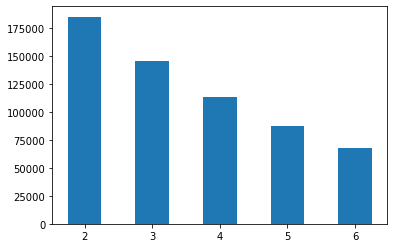

In [20]:
plt.hist( ds.event_njets, bins=np.linspace(1.75,6.25,10))
plt.show()

In [21]:
batch_size = 1000
batch_sampler = JetEventsSampler(ds.event_njets, batch_size)

data_loader = DataLoader(ds, batch_sampler=batch_sampler)


In [20]:
# class JetPair(nn.Module):
#     def __init__(self, in_features,out_features):
#         super().__init__()
        
#         self.pairnet = nn.Sequential(
#             nn.Linear(2*in_features, 100),
#             nn.ReLU(),
#             nn.Linear(100, 50),
#             nn.ReLU(),
#             nn.Linear(50, out_features))
            
        

#     def forward(self, inp):
        
#         n = inp.shape[1]
#         m2 = inp.unsqueeze(1).permute(0, 2, 1, 3).repeat(1, 1, n, 1)
#         m1 = m2.transpose(1,2)
#         block = torch.cat([m1,m2],dim=3)
#         x = self.pairnet(block)
#         x[:, torch.arange(n), torch.arange(n)] = 0 #make the diagonal 0
#         #print(x.shape)
#         x = torch.sum(x,dim=2)
#         #print(x.shape)
#         return x

class DeepSet(nn.Module):
    def __init__(self, in_features,node_eff_layers, correction_layers):

        super(DeepSet, self).__init__()


        jet_eff_layers = []
        jet_eff_layers.append(nn.Linear(in_features,node_eff_layers[0]))
        jet_eff_layers.append(nn.ReLU())
            
        for hidden_i in range(1,len(node_eff_layers)):
            jet_eff_layers.append(nn.Linear(node_eff_layers[hidden_i-1],node_eff_layers[hidden_i]))
            jet_eff_layers.append(nn.ReLU())
            
        jet_eff_layers.append(nn.Linear(node_eff_layers[-1],1))
        jet_eff_layers.append(nn.Sigmoid())
        
        self.jet_eff = nn.Sequential( *jet_eff_layers )
        
        eff_correction_layers = []
        eff_correction_layers.append(nn.Linear(2*in_features,correction_layers[0]))
        eff_correction_layers.append(nn.ReLU())
            
        for hidden_i in range(1,len(correction_layers)):
            eff_correction_layers.append(nn.Linear(correction_layers[hidden_i-1],correction_layers[hidden_i]))
            eff_correction_layers.append(nn.ReLU())
            
        eff_correction_layers.append(nn.Linear(correction_layers[-1],1))
        eff_correction_layers.append(nn.Sigmoid())
        
        self.eff_correction = nn.Sequential( *eff_correction_layers )
        
        
        
    def forward(self, inp):
        
        effs = self.jet_eff(inp)
        

        B, n, _ = inp.shape
        m2 = inp.repeat(1, n, 1)[:,np.delete(np.arange(n*n),[i*n+i for i in range(n)]),:]
        m1 = inp[:,np.repeat(np.arange(n),n-1),:]
        block = torch.cat([m1,m2],dim=2)
        block = block.view(B,n,n-1,-1)
        correction = self.eff_correction(block)
        
        correction = torch.prod(correction,dim=2)
        out = torch.mul(effs,correction)
        return out


# class DeepSetLayer(nn.Module):
#     def __init__(self, original_in_features, in_features, out_features):
  
#         super(DeepSetLayer, self).__init__()
    
#         self.jetPair = JetPair(original_in_features+in_features,out_features)
        
#         #self.layer1 = nn.Linear(original_in_features+in_features, out_features)
        

#     def forward(self, inp):
#         # x.shape = (B,N,C)
        
#         jet_pairs_sum = self.jetPair(inp)
        

#         x = jet_pairs_sum
        
#         # normalization
#         x = x / torch.norm(x, p='fro', dim=1, keepdim=True)  # BxCxN / Bx1xN
        
#         #x = x.transpose(1, 2) # B,C,N -> B,N,C
        
#         return x
    


In [399]:
inp = torch.FloatTensor([[[1,1,1],[2,2,2],[3,3,3],[4,4,4]]])
B, n, _ = inp.shape
m2 = inp.repeat(1, n, 1)[:,np.delete(np.arange(n*n),[i*n+i for i in range(n)]),:]
m1 = inp[:,np.repeat(np.arange(n),n-1),:]
block = torch.cat([m1,m2],dim=2)
block = block.view(B,n,n-1,-1)

In [400]:
#block.fill_diagonal_(0)

In [401]:
block.shape

torch.Size([1, 4, 3, 6])

In [403]:
torch.prod(block,dim=2).shape

torch.Size([1, 4, 6])

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [4., 4., 4.],
         [4., 4., 4.],
         [4., 4., 4.]]])

In [21]:
net = DeepSet(4,[50,50],[256,128,50])
net.train();

In [408]:
for x,y,label in data_loader:
    output = net(x)
    break

In [44]:
net.load_state_dict( torch.load('model_18.pt',map_location='cpu'))

<All keys matched successfully>

In [253]:
label.view(-1).shape

torch.Size([2010])

In [293]:
loss_vs_epoch = []

In [409]:
lossfunc = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [410]:
from IPython.display import clear_output



epochs = 30
net.train()

if len(loss_vs_epoch) == 0:
    first_epoch = 0
else:
    first_epoch = len(loss_vs_epoch)

for epoch in range(first_epoch,first_epoch+epochs):
    if epoch == 20:
        optimizer = optim.Adam(net.parameters(), lr=0.005)
    if epoch == 60:
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    batch_losses = []
    for x,y,label in tqdm(data_loader):
        optimizer.zero_grad()
        
        output = net(x)
        
        output = output.view(-1)
        y = y.view(-1)
        
        #y = y.double()
        #y = y.unsqueeze(-1)
        b_mask = torch.where(label.view(-1)==1)
        b_loss = lossfunc(output[b_mask],y[b_mask])
        
        c_mask = torch.where(label.view(-1)==2)
        c_loss = lossfunc(output[c_mask],y[c_mask])
        
        u_mask = torch.where(label.view(-1)==3)
        u_loss = lossfunc(output[u_mask],y[u_mask])
        
        loss = c_loss+b_loss+u_loss #lossfunc(output.view(-1),y.view(-1))
        batch_losses.append([loss.item(),b_loss.item()]) #,c_loss.item(),u_loss.item()])
        
        loss.backward()  
        optimizer.step()
    batch_losses = np.array(batch_losses)
    loss_vs_epoch.append([epoch]+[np.mean(batch_losses[:,i]) for i in range(2)])
    clear_output()
    print(loss_vs_epoch[-1])
    


KeyboardInterrupt: 

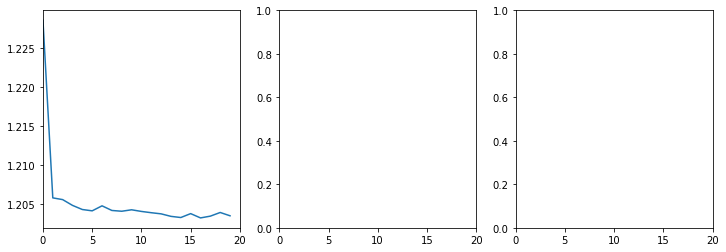

In [259]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,1])
# ax[1].plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,3])
# ax[2].plot(np.array(loss_vs_epoch)[:,0],np.array(loss_vs_epoch)[:,4])
#ax.set_ylim(0,1)
for i in range(3):
    ax[i].set_xlim(0,len(loss_vs_epoch))
plt.show()

## apply the trained network to the validation sample, and compute the efficiencies

In [22]:
valid_ds = JetEventsDataset(jet_valid_data)


In [29]:
def eval_on_ds(ds):
    indx_list = []
    predictions = []


    for jets_in_event in  tqdm(range(2,np.amax(ds.event_njets)+1)): #tqdm(

        event_indxs = np.where(ds.event_njets == jets_in_event)[0]
        if len(event_indxs) < 1:
            continue
        indx_list+=list(event_indxs)

        input_batch = np.stack([ds[i][0] for i in event_indxs])
        
        output =  net( torch.tensor( input_batch ) ).data.numpy()

        predictions+=list( output )


    sorted_predictions = [x for _, x in sorted(zip(indx_list, predictions))]
    
    return sorted_predictions
net.load_state_dict( torch.load('models/all_model_20.pt',map_location='cpu'))
net.eval();

sorted_predictions = eval_on_ds(valid_ds)
jet_valid_data['NN_predictions'] = np.concatenate( sorted_predictions )

In [421]:
apply_effmaps(jets_train_data)

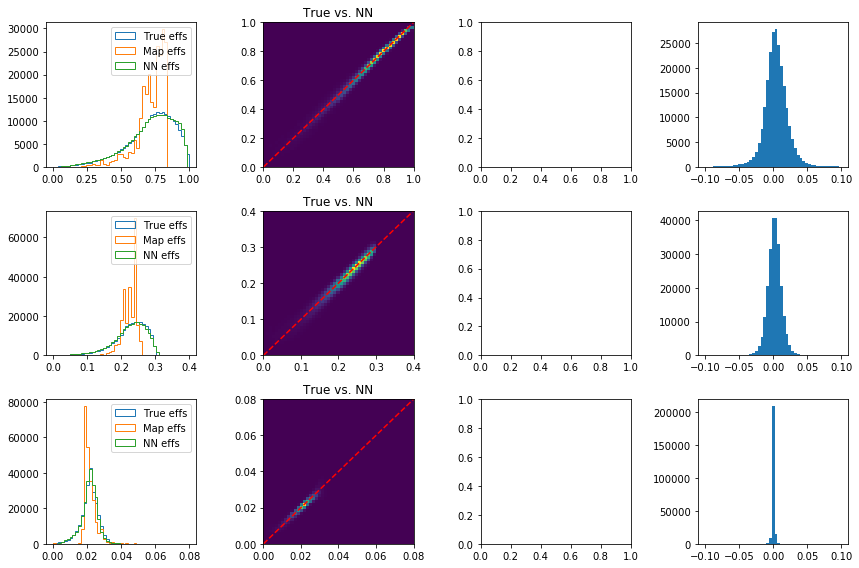

In [30]:
fig,ax = plt.subplots(3,4,figsize=(12,8))

flav_ranges = {
    1 : [0,1],
    2 : [0,0.4],
    3 : [0,0.08]
}

for flav_i,flav in enumerate([1,2,3]):
    flav_cut = jet_valid_data['jet_label'] == flav

    binning = np.linspace(flav_ranges[flav][0],flav_ranges[flav][1],50)

    ax[flav_i][0].hist( jet_valid_data['jet_eff'].loc[flav_cut] , bins=binning ,label='True effs',histtype='step')
    ax[flav_i][0].hist( jet_valid_data['map_eff'].loc[flav_cut] , bins=binning ,label='Map effs',histtype='step')
    ax[flav_i][0].hist( jet_valid_data['NN_predictions'].loc[flav_cut] , bins=binning ,label='NN effs',histtype='step')
    ax[flav_i][0].legend()
    ax[flav_i][1].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
                         jet_valid_data['NN_predictions'].loc[flav_cut] , 
                         bins=(binning,binning))
    ax[flav_i][1].set_title('True vs. NN')
    for i in range(1,2):
        ax[flav_i][i].plot([flav_ranges[flav][0],flav_ranges[flav][1]],
                       [flav_ranges[flav][0],flav_ranges[flav][1]],c='r',linestyle='--')
#     ax[flav_i][2].set_title('True vs. 2D EffMap')
#     ax[flav_i][2].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
#                          jet_valid_data['map_eff'].loc[flav_cut] , 
#                          bins=(binning,binning))
    ax[flav_i][3].hist( jet_valid_data['jet_eff'].loc[flav_cut]-jet_valid_data['NN_predictions'].loc[flav_cut] , 
                         bins=np.linspace(-0.1,0.1,50))
plt.tight_layout()
plt.show()

In [24]:
# sorted_predictions = eval_on_ds(valid_ds)
# jet_valid_data['NN_predictions'] = np.concatenate( sorted_predictions )

In [102]:
apply_effmaps(jet_valid_data)

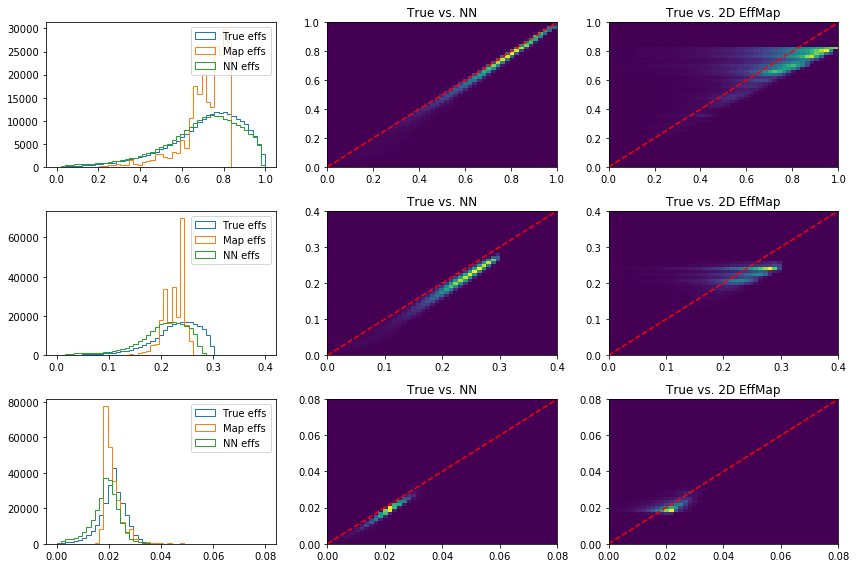

In [28]:
fig,ax = plt.subplots(3,3,figsize=(12,8))

flav_ranges = {
    1 : [0,1],
    2 : [0,0.4],
    3 : [0,0.08]
}

for flav_i,flav in enumerate([1,2,3]):
    flav_cut = jet_valid_data['jet_label'] == flav

    binning = np.linspace(flav_ranges[flav][0],flav_ranges[flav][1],50)

    ax[flav_i][0].hist( jet_valid_data['jet_eff'].loc[flav_cut] , bins=binning ,label='True effs',histtype='step')
    ax[flav_i][0].hist( jet_valid_data['map_eff'].loc[flav_cut] , bins=binning ,label='Map effs',histtype='step')
    ax[flav_i][0].hist( jet_valid_data['NN_predictions'].loc[flav_cut] , bins=binning ,label='NN effs',histtype='step')
    ax[flav_i][0].legend()
    ax[flav_i][1].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
                         jet_valid_data['NN_predictions'].loc[flav_cut] , 
                         bins=(binning,binning))
    ax[flav_i][1].set_title('True vs. NN')
    for i in range(1,3):
        ax[flav_i][i].plot([flav_ranges[flav][0],flav_ranges[flav][1]],
                       [flav_ranges[flav][0],flav_ranges[flav][1]],c='r',linestyle='--')
    ax[flav_i][2].set_title('True vs. 2D EffMap')
    ax[flav_i][2].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
                         jet_valid_data['map_eff'].loc[flav_cut] , 
                         bins=(binning,binning))

plt.tight_layout()
plt.show()

In [88]:
# for model_i in range(77,78):
#     net.load_state_dict( torch.load('model_'+str(model_i)+'.pt',map_location='cpu'))
#     net.eval();


#     sorted_predictions = eval_on_ds(valid_ds)
#     #sorted_predictions_training_set = eval_on_ds(ds)

#     jet_valid_data['NN_predictions'] = np.concatenate( sorted_predictions )

#     # fig,ax = plt.subplots(figsize=(6,6))

#     # ax.hist( jets_train_data['jet_eff'] , bins=np.linspace(0,1,50) ,label='True effs',histtype='step')
#     # ax.hist( jets_train_data['map_eff'] , bins=np.linspace(0,1,50) ,label='Map effs',histtype='step')
#     # ax.hist( jets_train_data['NN_predictions'] , bins=np.linspace(0,1,50) ,label='NN effs',histtype='step')
#     # ax.legend()

#     # plt.show()

#     fig,ax = plt.subplots(3,3,figsize=(12,8))

#     flav_ranges = {
#         1 : [0,1],
#         2 : [0,0.4],
#         3 : [0,0.08]
#     }

#     for flav_i,flav in enumerate([1,2,3]):
#         flav_cut = jet_valid_data['jet_label'] == flav

#         binning = np.linspace(flav_ranges[flav][0],flav_ranges[flav][1],50)

#         ax[flav_i][0].hist( jet_valid_data['jet_eff'].loc[flav_cut] , bins=binning ,label='True effs',histtype='step')
#         ax[flav_i][0].hist( jet_valid_data['map_eff'].loc[flav_cut] , bins=binning ,label='Map effs',histtype='step')
#         ax[flav_i][0].hist( jet_valid_data['NN_predictions'].loc[flav_cut] , bins=binning ,label='NN effs',histtype='step')
#         ax[flav_i][0].legend()
#         ax[flav_i][1].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
#                              jet_valid_data['NN_predictions'].loc[flav_cut] , 
#                              bins=(binning,binning))
#         ax[flav_i][1].set_title('True vs. NN')
#         for i in range(1,3):
#             ax[flav_i][i].plot([flav_ranges[flav][0],flav_ranges[flav][1]],
#                            [flav_ranges[flav][0],flav_ranges[flav][1]],c='r',linestyle='--')
#         ax[flav_i][2].set_title('True vs. 2D EffMap')
#         ax[flav_i][2].hist2d( jet_valid_data['jet_eff'].loc[flav_cut],
#                              jet_valid_data['map_eff'].loc[flav_cut] , 
#                              bins=(binning,binning))

#     plt.tight_layout()
#     plt.savefig('plots/model_'+str(model_i)+'.png')
#     plt.close()
#     #plt.show()


In [ ]:
effs_1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['map_eff'].values
effs_2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['map_eff'].values

tt_weights = {
 0: (1-effs_1)*(1-effs_2),
 1: (effs_1)*(1-effs_2)+(1-effs_1)*(effs_2),
 2: (effs_1)*(effs_2)
}



In [ ]:
eff1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['NN_predictions'].values
eff2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['NN_predictions'].values

tt_weights_NN = {
 0: (1-eff1)*(1-eff2),
 1: (eff1)*(1-eff2)+(1-eff1)*(eff2),
 2: (eff1)*(eff2)
}

In [ ]:
true_eff1 = jet_valid_data.loc[ jet_valid_data['subentry'] == 0 ]['jet_eff'].values
true_eff2 = jet_valid_data.loc[ jet_valid_data['subentry'] == 1 ]['jet_eff'].values

tt_weights_True = {
 0: (1-true_eff1)*(1-true_eff2),
 1: (true_eff1)*(1-true_eff2)+(1-true_eff1)*(true_eff2),
 2: (true_eff1)*(true_eff2)
}

In [ ]:
jet_1_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==0]
jet_2_valid_target = jet_valid_data['jet_tag'].values[jet_valid_data['subentry']==1]

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(16,8),gridspec_kw={'height_ratios':[2,1]})

tt_algos = {
    'Truth Tagging' : tt_weights,
    'Truth Tagging with NN' : tt_weights_NN,
    'True Efficiencies' : tt_weights_True
}


n_tag_range = {
    0 : 7500,
    1 : 7000,
    2 : 2000
}

for plot_i, ntags in enumerate([0,1,2]):
    
    
    ax_i = ax[0][plot_i]
    
    if ntags==0:
        tag_condition = (jet_1_valid_target == 0) & (jet_2_valid_target == 0)
    elif ntags==1:
        tag_condition = (((jet_1_valid_target == 1) & (jet_2_valid_target == 0)) 
                         | ((jet_1_valid_target == 0) & (jet_2_valid_target == 1)) )
    elif ntags==2:
        tag_condition = (jet_1_valid_target == 1) & (jet_2_valid_target == 1)
    
    mass_binning = np.linspace(20,1200,42)
    h_dt = ax_i.hist(event_df_valid['mass'].values[tag_condition]
                     ,bins=mass_binning,label='Direct Tagging')
    
    bin_centers = [(mass_binning[i+1]+mass_binning[i])/2 for i in range(len(mass_binning)-1)]
    ax[1][plot_i].plot([mass_binning[0],mass_binning[-1]],[1,1],color='k',linestyle='--')
    for algo, weights_dict in tt_algos.items():
        
        h_tt = ax_i.hist(event_df_valid['mass'],weights=weights_dict[ntags],histtype='step',
              bins=mass_binning,
              label=algo)
        ax[1][plot_i].plot(bin_centers,h_tt[0]/h_dt[0],label=algo+'/DT')
    
    
    ax[1][plot_i].set_ylim(0.7,1.3)
    ax[1][plot_i].legend()
    #ax_i.set_ylim(0,n_tag_range[ntags])
    ax_i.set_xlabel('Mass [GeV]')
    ax_i.set_title(str(ntags)+' Tag Region')
    ax_i.legend()
plt.tight_layout()
plt.show()